This notebook performs sanity check to make sure baseline (MMSE, Classic demod, Viterbi) working as expected.

* Inputs: (CFO + Channel Inference + AWGN) signals
* Outputs: Estimated message bits

Tests:
  * Baseline on inputs with no CFO, no Channel Interference
  * Baseline on inputs with no CFO, channel_tap = 2
  * Baseline on inputs with CFO = 1/100, channel_tap =2

## Environment Setup

In [1]:
# Import packages from other direction. Itis necessary if the project is structured as:
import multiprocessing as mp
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import scipy
from radioml.models import Baseline, MMSEEqualizer
from radioml.metrics import get_ber_bler
from radioml.dataset import RadioDataGenerator

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
sns.set_style("white")

## Define paramters

In [2]:
MOD_SCHEME   = 'QPSK'  # or {'BPSK', 'QPSK', 'QAM16', 'QAM64'}
NUM_PACKETS  = 100
PREAMBLE_LEN = 40
DATA_LEN     = 200
SNRs         = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0]

## Define Baseline (MSSE, Classic Demodulation, Viterbi)


In [3]:
mmse = MMSEEqualizer(equalizer_order=5, update_rate=0.1)
baseline = Baseline(equalizer=mmse, modulation_scheme=MOD_SCHEME)

## Define benchmark func

In [4]:
def run_benchmark(radio, num_packets, snr_range, omega, channel_len, seed=None):
    bit_error_rates, block_error_rates = [], []
    for snr in snr_range:
        generator = radio.end2end_data_generator(OMEGA, snr, 
                                                 batch_size=num_packets, 
                                                 seed=seed)
        [preambles, corrupted_packets], [message_bits, w, channels] = next(generator)
        
        # Extract preamble_conv and convert to complex
        preambles = preambles.view(complex)
        convolved_preamble = np.array(corrupted_packets[:, :radio.preamble_len, :]).view(complex)
        convolved_data     = np.array(corrupted_packets[:, radio.preamble_len:, :]).view(complex)

        # Esimate message bits with Baseline
        with mp.Pool(mp.cpu_count()) as pool:
            baseline_results = pool.starmap(baseline,[(i,j,k) for i,j,k in 
                                        zip(convolved_data, convolved_preamble, preambles)])
            baseline_results = np.array(baseline_results)

        ber, bler = get_ber_bler(baseline_results, np.squeeze(message_bits, -1))
        print('SNR_dB = {:5.2f} : BER = {:.10f} | BLER ={:.10f} '.format(snr, ber, bler))
        bit_error_rates.append([ber, ber])
        block_error_rates.append([bler, bler])
        
    return bit_error_rates, block_error_rates

##  Baseline with No Intersymbol Interference (Channel_len = 1)

In [5]:
CHANNEL_LEN  = 1        # Ignore channel interference
OMEGA        = 1/10000  # no CFO.
radio        = RadioDataGenerator(DATA_LEN, 
                                  PREAMBLE_LEN, 
                                  CHANNEL_LEN, 
                                  modulation_scheme=MOD_SCHEME)
bers, blers = run_benchmark(radio, 
                            NUM_PACKETS,
                            snr_range=SNRs, 
                            omega=OMEGA,
                            channel_len=CHANNEL_LEN,
                            seed=2018)

SNR_dB =  0.00 : BER = 0.2773000000 | BLER =1.0000000000 
SNR_dB =  2.00 : BER = 0.1298000000 | BLER =1.0000000000 
SNR_dB =  4.00 : BER = 0.0342500000 | BLER =0.9100000000 
SNR_dB =  6.00 : BER = 0.0039500000 | BLER =0.2800000000 
SNR_dB =  8.00 : BER = 0.0005500000 | BLER =0.0600000000 
SNR_dB = 10.00 : BER = 0.0000500000 | BLER =0.0100000000 
SNR_dB = 12.00 : BER = 0.0000000000 | BLER =0.0000000000 


##  Baseline with Intersymbol Interference (Channel_len = 2)

In [6]:
CHANNEL_LEN  = 2
OMEGA        = 1/10000  # no CFO.
radio        = RadioDataGenerator(DATA_LEN, PREAMBLE_LEN, 
                                  CHANNEL_LEN, 
                                  modulation_scheme=MOD_SCHEME)

bers1, blers1 = run_benchmark(radio, 
                              NUM_PACKETS,
                              snr_range=SNRs, 
                              omega=OMEGA, 
                              channel_len=CHANNEL_LEN,
                              seed=2018)

SNR_dB =  0.00 : BER = 0.3097500000 | BLER =1.0000000000 
SNR_dB =  2.00 : BER = 0.1862000000 | BLER =1.0000000000 
SNR_dB =  4.00 : BER = 0.0915500000 | BLER =0.9900000000 
SNR_dB =  6.00 : BER = 0.0375500000 | BLER =0.7800000000 
SNR_dB =  8.00 : BER = 0.0158500000 | BLER =0.6400000000 
SNR_dB = 10.00 : BER = 0.0081000000 | BLER =0.5000000000 
SNR_dB = 12.00 : BER = 0.0037500000 | BLER =0.3500000000 


##  Baseline with Intersymbol Interference (Channel_len = 2), CFO = 1/200

In [7]:
CHANNEL_LEN  = 2
OMEGA        = 1/200  # no CFO.
radio        = RadioDataGenerator(DATA_LEN, 
                                  PREAMBLE_LEN, 
                                  CHANNEL_LEN, 
                                  modulation_scheme=MOD_SCHEME)
bers2, blers2 = run_benchmark(radio, 
                              NUM_PACKETS,
                              snr_range=SNRs, 
                              omega=OMEGA, 
                              channel_len=CHANNEL_LEN, 
                              seed=2018)

SNR_dB =  0.00 : BER = 0.3743500000 | BLER =1.0000000000 
SNR_dB =  2.00 : BER = 0.2822500000 | BLER =1.0000000000 
SNR_dB =  4.00 : BER = 0.1928000000 | BLER =1.0000000000 
SNR_dB =  6.00 : BER = 0.1268500000 | BLER =0.9100000000 
SNR_dB =  8.00 : BER = 0.0966500000 | BLER =0.8100000000 
SNR_dB = 10.00 : BER = 0.0766500000 | BLER =0.7400000000 
SNR_dB = 12.00 : BER = 0.0667000000 | BLER =0.7000000000 


## Visualize Result

In [8]:
def visualize_ber_bler(ax1, ax2, ber_logs, bler_logs, snr_range, title, style='*-'):
    ax1.plot(snr_range, np.array(ber_logs).T[1, :], style, label=title,)
    ax1.set_xlabel('SNR (in dB)')
    ax1.set_ylabel('Bit Error Rate (BER)')
    ax1.grid(True,'both')
    ax1.set_xlim(np.min(snr_range), np.max(snr_range))
    
    ax2.plot(snr_range, np.array(bler_logs).T[1,:], style, label=title)
    ax2.set_xlabel('SNR (in dB)')
    ax2.set_ylabel('Block Error Rate (BLER)')
    ax2.set_xlim(np.min(snr_range), np.max(snr_range))

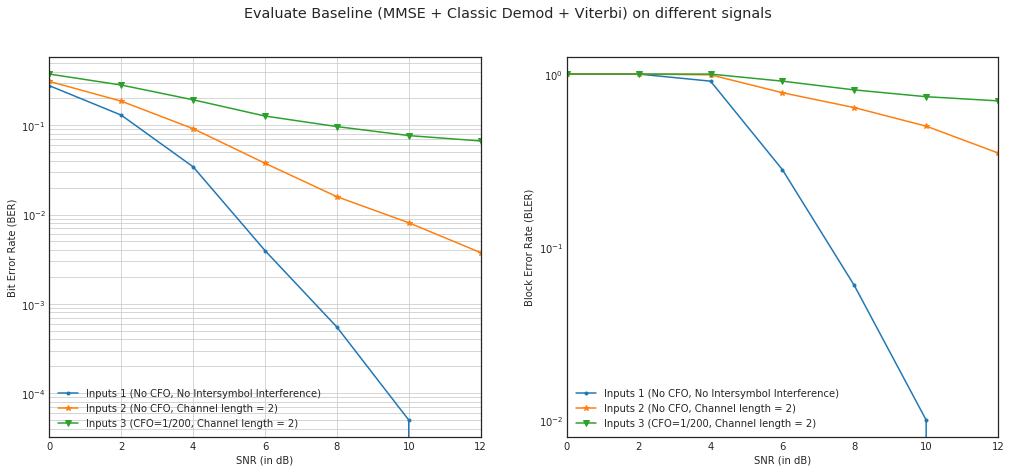

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))
fig.suptitle('Evaluate Baseline (MMSE + Classic Demod + Viterbi) on different signals', 
             fontsize='x-large')

visualize_ber_bler(ax1, ax2, bers, blers, SNRs, 'Inputs 1 (No CFO, No Intersymbol Interference)', '.-')
visualize_ber_bler(ax1, ax2, bers1, blers1, SNRs, 'Inputs 2 (No CFO, Channel length = 2)', '*-')
visualize_ber_bler(ax1, ax2, bers2, blers2, SNRs,  'Inputs 3 (CFO=1/200, Channel length = 2)', 'v-')

ax1.semilogy()
ax2.semilogy()
ax1.legend(loc=3)
_ =ax2.legend(loc=3)